# 最大カット問題

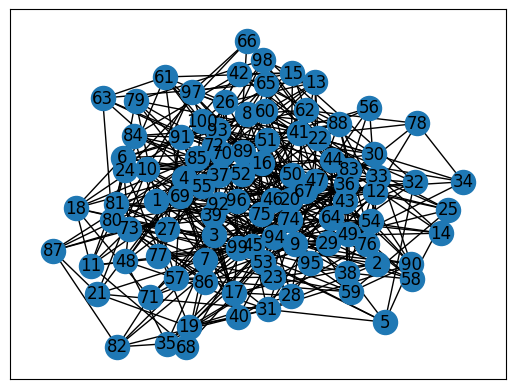

In [1]:
import random

random.seed(3)

def make_data(n, prob):
    """make_data: prepare data for a random graph
    Parameters:
        - n: number of vertices
        - prob: probability of existence of an edge, for each pair of vertices
    Returns a tuple with a list of vertices and a list edges.
    """
    V = range(1, n + 1)
    E = [(i, j) for i in V for j in V if i < j and random.random() < prob]
    return V, E

V, E = make_data(100, 0.1)

import networkx as nx

nx.draw_networkx(nx.from_edgelist(E))

In [2]:
print('Number of edges:', len(E))

Number of edges: 487


線形の定式化

\begin{align*}
&\mathrm{Maximize\ } && \sum_{(i,j)\in E} w_{ij} y_{ij} \\
&\mathrm{subject\ to\ } && x_i + x_j \ge y_{ij} \quad (i,j) \in E \\
&&& 2 - x_i - x_j \ge y_{ij} \quad (i,j) \in E \\
&&& x_i - x_j \le y_{ij} \quad (i,j) \in E \\
&&& x_j - x_i \le y_{ij} \quad (i,j) \in E \\
&&& x_i \in \{0,1\} \quad i \in V \\
&&&\ y_{ij} \in \{0,1\} \quad (i,j) \in E 
\end{align*}

In [7]:
from pyscipopt import Model, quicksum

def maxcut(V, E):
    """maxcut -- model for the graph maxcut problem
    Parameters:
        - V: set/list of nodes in the graph
        - E: set/list of edges in the graph
    Returns a model, ready to be solved.
    """
    model = Model("maxcut")
    x = {}
    y = {}
    for i in V:
        x[i] = model.addVar(vtype="B", name=f"x({i})")
    for (i, j) in E:
        y[i, j] = model.addVar(vtype="B", name=f"y({i},{j})")
    #model.update()

    for (i, j) in E:
        model.addCons(x[i] + x[j] >= y[i, j], f"Edge({i},{j})")
        model.addCons(2 - x[j] - x[i] >= y[i, j], f"Edge({j},{i})")
        model.addCons(x[i] - x[j] <= y[i, j], f"EdgeLB1({i},{j})")
        model.addCons(x[j] - x[i] <= y[i, j], f"EdgeLB2({j},{i})")

    model.setObjective(
        quicksum(y[i, j] for (i, j) in E),
        sense='maximize'
    )

    #model.update()
    #model.__data = x
    return model

In [8]:
model = maxcut(V, E)
model.optimize()

feasible solution found by trivial heuristic after 0.0 seconds, objective value 0.000000e+00
presolving:
(round 1, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 1948 upgd conss, 0 impls, 0 clqs
   (0.0s) probing: 51/587 (8.7%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (2 rounds: 2 fast, 2 medium, 2 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 587 variables (587 bin, 0 int, 0 impl, 0 cont) and 1948 constraints
   1948 constraints of type <logicor>
transformed objective value is always integral (scale: 1)
Presolving Time: 0.01
transformed 1/1 o

 15.75%| unknown
 48.3s|     1 |     0 |635647 |     - |   293M |   0 | 587 |2759 |2442 |  79 |  9 | 616 | 713 | 4.097685e+02 | 3.540000e+02 |  15.75%| unknown
 48.4s|     1 |     0 |636298 |     - |   302M |   0 | 587 |2760 |2449 |  86 | 10 | 617 | 713 | 4.097685e+02 | 3.540000e+02 |  15.75%| unknown
 48.5s|     1 |     0 |636959 |     - |   302M |   0 | 587 |2761 |2457 |  94 | 11 | 618 | 713 | 4.097685e+02 | 3.540000e+02 |  15.75%| unknown
 48.5s|     1 |     0 |637704 |     - |   303M |   0 | 587 |2762 |2463 | 100 | 12 | 619 | 713 | 4.097685e+02 | 3.540000e+02 |  15.75%| unknown
 48.6s|     1 |     0 |638361 |     - |   303M |   0 | 587 |2763 |2467 | 104 | 13 | 620 | 713 | 4.097685e+02 | 3.540000e+02 |  15.75%| unknown
 48.6s|     1 |     0 |638744 |     - |   303M |   0 | 587 |2764 |2472 | 109 | 14 | 621 | 713 | 4.097685e+02 | 3.540000e+02 |  15.75%| unknown
 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |

二次錐定式化 (Second-order cone)

\begin{align*}
&\mathrm{Maximize\ } &&\sum_{(i,j)\in E} w_{ij} z_{ij} \\
&\mathrm{subject\ to\ } &&(x_i + x_j - 1)^2 \le s_{ij} \quad (i,j) \in E \\
&&& (x_i - x_j)^2 \le z_{ij} \quad (i,j) \in E \\
&&& s_{ij} + z_{ij} = 1 \quad (i,j) \in E \\
&&& x_i \in \{0,1\} \quad i \in V \\
&&&\ z_{ij}, s_{ij} \in \{0,1\} \quad (i,j) \in E 
\end{align*}

**二次錐最適化による緩和問題のcvxpy実装**

すべての変数をまとめて $X = (x, s, z)$ と書くと，
各 $e \in E$ に対して
$|| A_e X + b_e ||^2 \le c_e^\top X$
と制約条件を表現する．
一般には $A_e$ は行列だが，今回は行ベクトルとしてとれる (二乗が一つだけの形なので)

以下では $e \in E$ を辺の添字 $\in \{0,\ldots, |E|-1\}$ と同一視する．

$(x_i + x_j - 1)^2 \le s_{ij}$ は，
$
(A_e)_{i} = (A_e)_{j} = 1, b_e = - 1, (c_e)_{n + e} = 1
$
, 他の成分は0

$(x_i - x_j)^2 \le z_{ij}$ は，
$
(A_e)_{i} = 1, (A_e)_{j} = - 1, (c_e)_{n + |E| + e} = 1
$
, 他の成分は0

In [3]:
import numpy as np
import cvxpy as cp

def maxcut_cvxpy(V, E):
    # Format:
    # V = [1, 2, ..., n]
    # E = [(1,2), ...]

    n_node = len(V)
    n_edge = len(E)
    n_var = n_node + 2 * n_edge

    x = cp.Variable(n_var)

    f = np.zeros(n_var)
    for e, (i,j) in enumerate(E):
        f[n_node + e] = 1

    A = []
    b = []
    c = []

    for e, (i,j) in enumerate(E):
        A_sub = np.zeros((1, n_var))
        A_sub[0,i] = 1
        A_sub[0,j] = 1
        A.append(A_sub)
        b.append(-1)
        c_sub = np.zeros(n_var)
        c_sub[n_node + e] = 1
        c.append(c_sub)
    
    for e, (i,j) in enumerate(E):
        A_sub = np.zeros((1, n_var))
        A_sub[0,i] = 1
        A_sub[0,j] = -1
        A.append(A_sub)
        b.append(0)
        c_sub = np.zeros(n_var)
        c_sub[n_node + n_edge + e] = 1
        c.append(c_sub)

    F = np.zeros((n_edge, n_var))
    for e, (i,j) in enumerate(E):
        F[e, n_node + e] = 1
        F[e, n_node + n_edge + e] = 1
    g = np.ones(n_edge)

    soc_constraints = [
        cp.SOC(c[i].T @ x, A[i] @ x + b[i]) for i in range(len(A))
    ]
    prob = cp.Problem(cp.Maximize(f.T@x),
                    soc_constraints + [F @ x == g])
    return prob, x

(CVXPY) Jun 29 07:49:14 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.12.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 29 07:49:14 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.12.0. Please open a feature request on cvxpy to enable support for this version.')


In [4]:
prob, x = maxcut_cvxpy(V, E)
prob.solve()

np.float64(486.9999965106755)

In [11]:
solution = np.round(x.value, decimals=5)
print(solution[:len(V)])
print(solution[len(V):len(V)+len(E)])

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

解の487という値は辺の数 `len(E)` と一致する。おそらく緩和問題の自明な解のようなものがあって、最初は意味のある解が出てこず、分枝限定法を進めるうちに緩和の意味が出てくる？

上を見ると全て整数の解が出ているようだが、そういえば線形の場合は緩和問題で整数解が出てきたらそれが元問題の最適解だったはずだが二次になるとそうではなくなる？その場合最適性の判定が難しくなるのだろうか？

SCIP による最適化
(上は緩和問題だが下は元問題の解を求める)

In [ ]:
def maxcut_soco(V, E):
    """maxcut_soco -- model for the graph maxcut problem
    Parameters:
        - V: set/list of nodes in the graph
        - E: set/list of edges in the graph
    Returns a model, ready to be solved.
    """
    model = Model("max cut -- scop")
    x, s, z = {}, {}, {}
    for i in V:
        x[i] = model.addVar(vtype="B", name=f"x({i})")
    for (i, j) in E:
        s[i, j] = model.addVar(vtype="C", name=f"s({i},{j})")
        z[i, j] = model.addVar(vtype="C", name=f"z({i},{j})")
    #model.update()

    for (i, j) in E:
        model.addCons((x[i] + x[j] - 1) * (x[i] + x[j] - 1) <= s[i, j], f"S({i},{j})")
        model.addCons((x[j] - x[i]) * (x[j] - x[i]) <= z[i, j], f"Z({i},{j})")
        model.addCons(s[i, j] + z[i, j] == 1, f"P({i},{j})")

    model.setObjective(
        quicksum(z[i, j] for (i, j) in E), 
        sense='maximize'
    )

    #model.update()
    #model.__data = x
    return model

In [ ]:
model = maxcut_soco(V, E)
model.optimize()

presolving:
(round 1, fast)       487 del vars, 487 del conss, 0 add conss, 974 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, exhaustive) 487 del vars, 487 del conss, 487 add conss, 974 chg bounds, 0 chg sides, 0 chg coeffs, 974 upgd conss, 0 impls, 0 clqs
(round 3, fast)       487 del vars, 487 del conss, 487 add conss, 974 chg bounds, 0 chg sides, 0 chg coeffs, 974 upgd conss, 0 impls, 974 clqs
(round 4, exhaustive) 487 del vars, 974 del conss, 487 add conss, 974 chg bounds, 0 chg sides, 0 chg coeffs, 974 upgd conss, 0 impls, 974 clqs
   (0.0s) probing: 51/1074 (4.7%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (5 rounds: 5 fast, 3 medium, 3 exhaustive):
 487 deleted vars, 974 deleted constraints, 487 ad

QUBO (制約なし二値最適化)　定式化

\begin{align*}
&\mathrm{Maximize\ } && \sum_{(i,j)\in E} w_{ij} (1 - x_i x_j) \\
&\mathrm{subject\ to\ } && x_i \in \{-1, 1\} \quad i \in V
\end{align*}

0-1変数に直す

\begin{align*}
&\mathrm{Maximize\ } && \sum_{(i,j)\in E} w_{ij} (x_i + x_j - 2 x_i x_j) \\
&\mathrm{subject\ to\ } && x_i \in \{0, 1\} \quad i \in V
\end{align*}

In [9]:
def maxcut_qubo(V, E):

    model = Model("max cut -- qubo")
    x = {}
    for i in V:
        x[i] = model.addVar(vtype="B", name=f"x({i})")
    z = model.addVar(name="objective")

    model.addCons(
        z <= quicksum(
            (x[i] + x[j] - 2 * x[i] * x[j]) for i, j in E
        )
    )

    model.setObjective(
        z,
        sense='maximize'
    )

    return model

In [10]:
model = maxcut_qubo(V, E)
model.optimize()

feasible solution found by trivial heuristic after 0.0 seconds, objective value 0.000000e+00
presolving:
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 1 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, exhaustive) 0 del vars, 0 del conss, 487 add conss, 1 chg bounds, 0 chg sides, 0 chg coeffs, 1 upgd conss, 0 impls, 0 clqs
   (0.0s) probing cycle finished: starting next cycle
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (3 rounds: 3 fast, 2 medium, 2 exhaustive):
 0 deleted vars, 0 deleted constraints, 487 added constraints, 1 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 101 cliques
presolved problem has 588 variables (100 bin, 0 int, 487 impl, 1 cont) and 488 constraints
    487 constraints of type <and>
      1 constraints of type <linear>
Presolving Time: 0.02
transformed 1/1 